In [1]:
%matplotlib notebook

In [2]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
from s2 import S2Cell, S2LatLng, S2LatLngRect, S2RegionCoverer
from shapely.geometry import Polygon

In [3]:
def plot(min_level, max_level, max_cells):

    plt.figure(figsize=(5, 4), dpi=200)

    proj = cimgt.GoogleTiles()
    ax = plt.axes(projection=proj.crs)
    ax.add_image(proj, 17)

    # cartopy extent order is (x0, x1, y0, y1) or (lon0, lon1, lat0, lat1)
    ax.set_extent([-3.478665, -3.471724, 50.726045, 50.728911])

    # our bounding box of interest
    lat0, lon0 = 50.726771, -3.476471
    lat1, lon1 = 50.728089, -3.473832

    # shapely order is (x, y) or (lon, lat)
    bbox = Polygon([(lon0, lat0), (lon0, lat1),
                    (lon1, lat1), (lon1, lat0)])

    # s2 order is (y, x) or (lat, lon)
    region_rect = S2LatLngRect(
        S2LatLng.FromDegrees(lat0, lon0),
        S2LatLng.FromDegrees(lat1, lon1))

    coverer = S2RegionCoverer()
    coverer.set_min_level(min_level)
    coverer.set_max_level(max_level)
    coverer.set_max_cells(max_cells)
    covering = coverer.GetCovering(region_rect)

    geoms = []
    for cellid in covering:
        new_cell = S2Cell(cellid)
        vertices = []
        for i in range(0, 4):
            vertex = new_cell.GetVertex(i)
            latlng = S2LatLng(vertex)
            # shapely vertex order is (x, y) or (lon, lat)
            vertices.append((latlng.lng().degrees(),
                             latlng.lat().degrees()))
        geo = Polygon(vertices)
        geoms.append(geo)

    print("Total Geometries: {}".format(len(geoms)))

    pc = ccrs.PlateCarree()
    ax.add_geometries([bbox], pc, facecolor=(0, 1, 0, .2), edgecolor=(0, 0, 0, 1))
    ax.add_geometries(geoms, pc, facecolor='coral', edgecolor='black', alpha=0.4)

    plt.show()

<IPython.core.display.Javascript object>


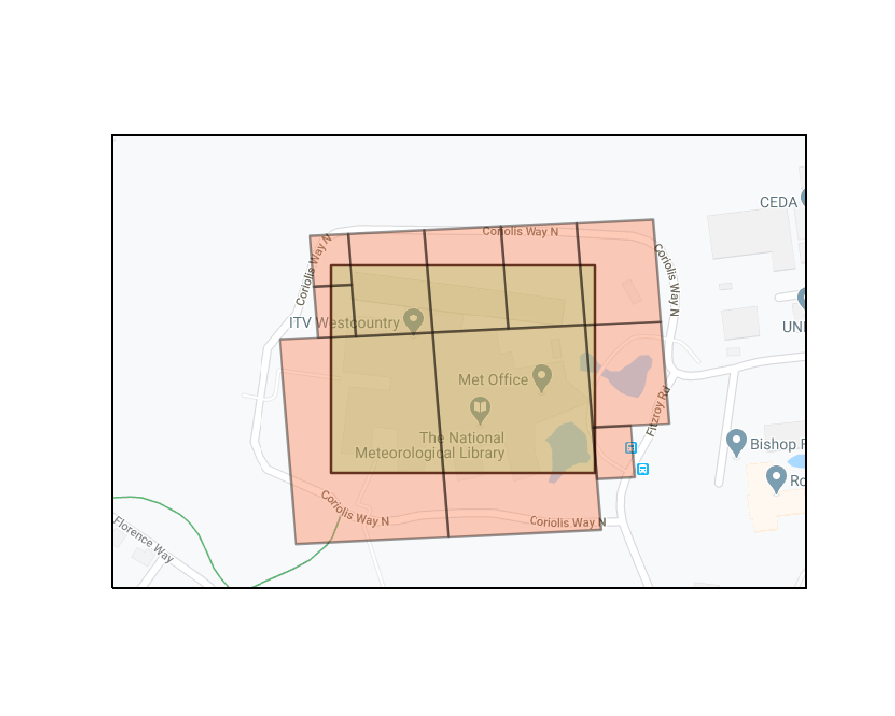

Total Geometries: 10


In [4]:
#
# adjust these arguments to explore the S2LatLngRect...
#
plot(min_level=4, max_level=18, max_cells=10)